# Analisi del dataset "Restaurants and Consumers"
1. Analisi preliminare del dataset per raccogliere informazioni sui ristoranti e sui consumatori.
2. Ricerca di relazioni fra alcune caratteristiche di un ristorante e la valutazione ricevuta.
3. Analisi della domanda e dell'offerta per ogni tipologia di cucina.
4. Analisi sul tasso di frequenza dei voti.
5. Sistema di raccomandazione basato sulla popolarità di un ristorante e sul tipo di cucina più apprezzata.
6. Sistema di raccomandazione basato su Collaborative Filtering utilizzando MLlib.


---

## 0 Inizializzazione

### 0.1 Configurazione strumenti di Data Analysis

##### PySpark

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder \
    .master("local") \
    .appName("Restaurant Analisys") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

##### MLlib

In [2]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

##### Pandas

In [3]:
import pandas as pd

import geopandas as gpd
import contextily as ctx

##### Altre librerie

In [4]:
from matplotlib import *
import matplotlib.pyplot as plt

import math

import numpy as np

from IPython.display import HTML, display
import tabulate

import seaborn as sns

### 0.2 Caricamento del dataset negli Spark DataFrames

In [5]:
payment_method = spark.read.format('csv').options(header='true').load("dataset/chefmozaccepts.csv")
cuisine = spark.read.format('csv').options(header='true').load("dataset/chefmozcuisine.csv")
parking = spark.read.format('csv').options(header='true').load("dataset/chefmozparking.csv")
locations = spark.read.format('csv').options(header='true').load("dataset/geoplaces2.csv")
user_cuisine = spark.read.format('csv').options(header='true').load("dataset/usercuisine.csv")
user_payment = spark.read.format('csv').options(header='true').load("dataset/userpayment.csv")
user_profiles = spark.read.format('csv').options(header='true').load("dataset/userprofile.csv")
ratings = spark.read.format('csv').options(header='true').load("dataset/rating_final.csv")

#### 0.2.1 Visualizzazione dei DataFrame

In [6]:
payment_method.printSchema()
payment_method.show()

cuisine.printSchema()
cuisine.show()

parking.printSchema()
parking.show()

locations.printSchema()
locations.show()

user_cuisine.printSchema()
user_cuisine.show()

user_payment.printSchema()
user_payment.show()

user_profiles.printSchema()
user_profiles.show()

ratings.printSchema()
ratings.show()

root
 |-- placeID: string (nullable = true)
 |-- Rpayment: string (nullable = true)

+-------+-------------------+
|placeID|           Rpayment|
+-------+-------------------+
| 135110|               cash|
| 135110|               VISA|
| 135110|MasterCard-Eurocard|
| 135110|   American_Express|
| 135110|   bank_debit_cards|
| 135109|               cash|
| 135107|               cash|
| 135107|               VISA|
| 135107|MasterCard-Eurocard|
| 135107|   American_Express|
| 135107|   bank_debit_cards|
| 135106|               cash|
| 135106|               VISA|
| 135106|MasterCard-Eurocard|
| 135105|               cash|
| 135104|               cash|
| 135104|               VISA|
| 135104|MasterCard-Eurocard|
| 135103|               cash|
| 135103|               VISA|
+-------+-------------------+
only showing top 20 rows

root
 |-- placeID: string (nullable = true)
 |-- Rcuisine: string (nullable = true)

+-------+-----------------+
|placeID|         Rcuisine|
+-------+-----------------+


---

## 1. Analisi preliminare del dataset per raccogliere informazioni sui ristoranti e sui consumatori.

### 1.1 Informazioni sul dataset

In [7]:
print("Total Restaurants: ",payment_method.select("placeID").distinct().count())

print("Payment Methods:")
payment_method.select("Rpayment").distinct().show()

print("Types of cuisine:")
cuisine.select("Rcuisine").distinct().show()

print("Total unique users that released a review: ",ratings.select("userID").distinct().count())
print("Total unique restaurants that were reviewed: ",ratings.select("placeID").distinct().count())

Total Restaurants:  615
Payment Methods:
+-------------------+
|           Rpayment|
+-------------------+
|   bank_debit_cards|
|  gift_certificates|
|           Discover|
|               VISA|
|MasterCard-Eurocard|
|Japan_Credit_Bureau|
|               Visa|
|   American_Express|
|               cash|
|      Carte_Blanche|
|             checks|
|        Diners_Club|
+-------------------+

Types of cuisine:
+-----------------+
|         Rcuisine|
+-----------------+
|    International|
|        Cafeteria|
|          Mexican|
|           Bakery|
|              Bar|
|          Turkish|
|         Armenian|
|          Persian|
|Dessert-Ice_Cream|
|        Ethiopian|
|             Thai|
|            Sushi|
|         Southern|
|          Chinese|
|          African|
|        Mongolian|
|         Hot_Dogs|
|        Fast_Food|
|           Polish|
|           Bagels|
+-----------------+
only showing top 20 rows

Total unique users that released a review:  138
Total unique restaurants that were

### 1.2 Analisi sugli utenti

#### 1.2.1 Analisi peso dei clienti

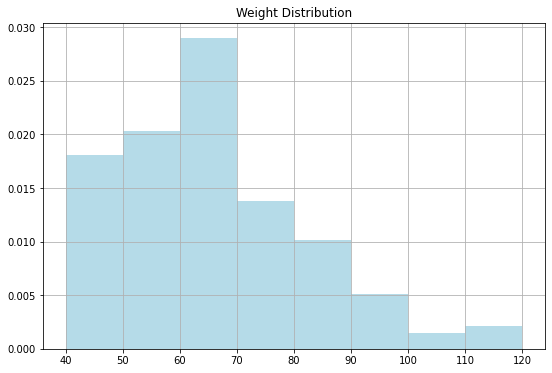

In [8]:
weight = user_profiles.rdd.map(lambda x: int(x[16])).collect()
plt.hist(weight, bins=8, color='lightblue', alpha=0.9, density=True, label="weight")
plt.title("Weight Distribution")
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.2 Analisi altezza dei clienti

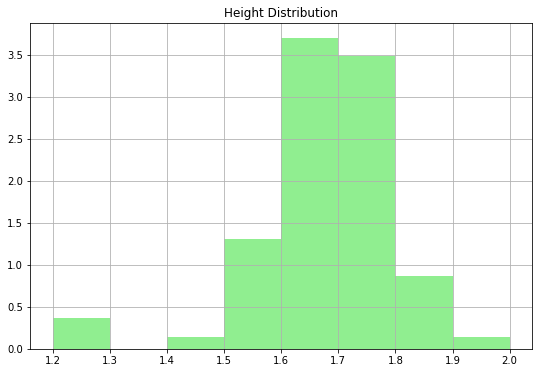

In [9]:
height = user_profiles.rdd.map(lambda x: float(x[18])).collect()
plt.hist(height, bins=8,color='lightgreen', density=True, label="height")
plt.grid(True)
plt.title("Height Distribution")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.3 Analisi budget dei clienti

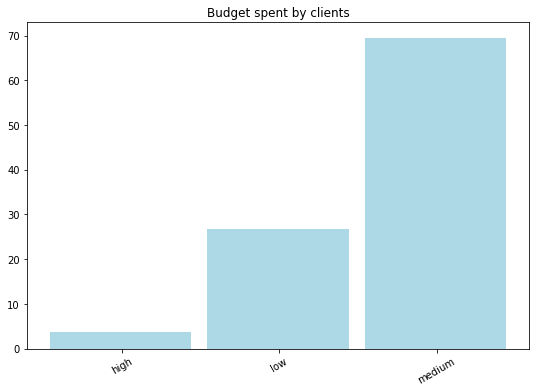

In [10]:
#MapReduce
count_by_budget = user_profiles.rdd.map(lambda fields: (fields[17], 1)).reduceByKey(lambda x, y: x + y).collect()
count_by_budget.pop(2)

x_axis1 = np.array([c[0] for c in count_by_budget]) # Budget
y_axis1 = np.array([c[1] for c in count_by_budget]) # Count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

#Figure Create
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Budget spent by clients")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.4 Analisi sulle abitudini di fumo

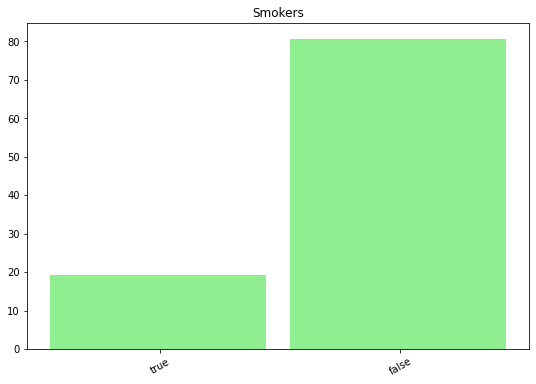

In [11]:
# MapReduce
count_smoker = user_profiles.rdd.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
count_smoker.pop(2)

x_axis1 = np.array([c[0] for c in count_smoker]) # Smoker boolean
y_axis1 = np.array([c[1] for c in count_smoker]) # Count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightgreen')
plt.xticks(rotation=30)
plt.title("Smokers")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.5 Analisi professione dei clienti

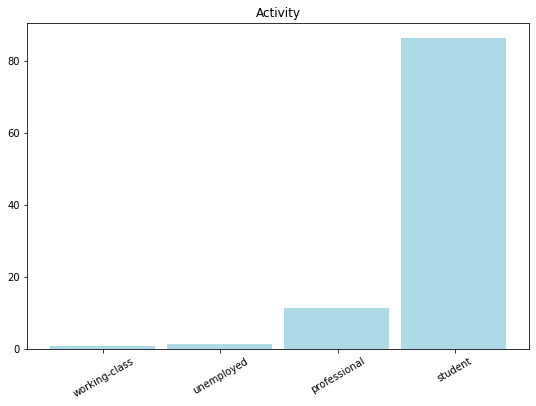

In [12]:
# MapReduce
count_activity = user_profiles.rdd.map(lambda fields: (fields[14], 1)).reduceByKey(lambda x, y: x + y).collect()
count_activity.pop(2)

x_axis1 = np.array([c[0] for c in count_activity]) # Type of activity
y_axis1 = np.array([c[1] for c in count_activity]) # Count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Activity")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.6 Analisi sul consumo di alcolici

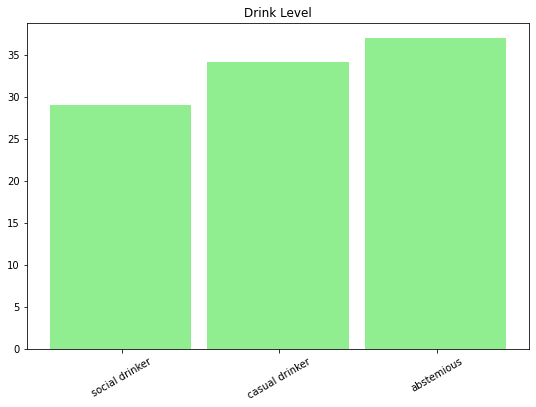

In [13]:
# MapReduce
count_drink_level = user_profiles.rdd.map(lambda fields: (fields[4], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_drink_level]) # Drink level
y_axis1 = np.array([c[1] for c in count_drink_level]) # Count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightgreen')
plt.xticks(rotation=30)
plt.title("Drink Level")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.7 Analisi delle date di nascita dei clienti

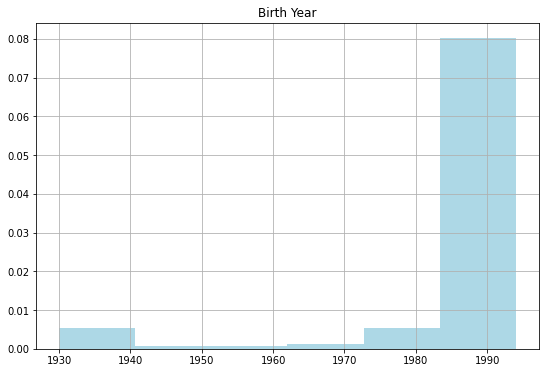

In [14]:
birth_year = user_profiles.rdd.map(lambda x: float(x[10])).collect()
plt.hist(birth_year, bins=6,color='lightblue',density=True,label="height")
plt.grid(True)
plt.title("Birth Year")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.8 Metodi di pagamento più diffusi tra i clienit

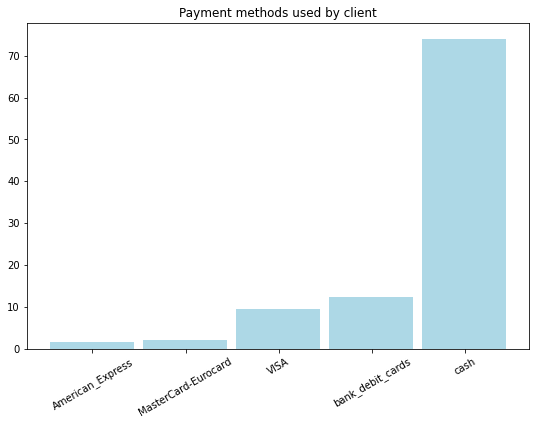

In [15]:
# MapReduce
count_user_payment_methods = user_payment.rdd.map(lambda fields: (fields[1], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_user_payment_methods]) # Type of payment
y_axis1 = np.array([c[1] for c in count_user_payment_methods]) # Count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Payment methods used by client")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.2.9 Clienti per tipologia di cucina

<AxesSubplot:ylabel='userID'>

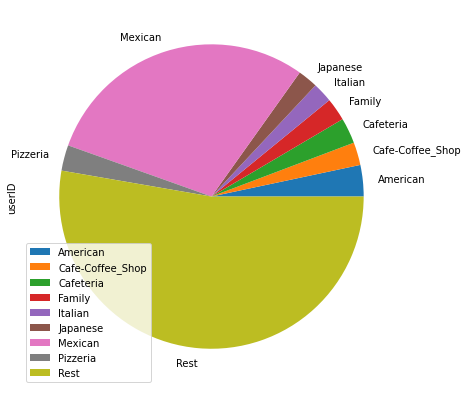

In [16]:
user_cuisine_pdf = user_cuisine.toPandas()
a = user_cuisine_pdf.groupby('Rcuisine').agg('count')

# Group minor contributors in "Rest" slice
a.loc['Rest'] = 0
for index, row in a.iterrows():
    if row['userID'] < 7:
        a.loc['Rest'] = a.loc['Rest'] + row['userID']
for index, row in a.iterrows():
    if row['userID'] < 7:
        a.drop(index, inplace=True)

# Pie Plot
a.plot.pie(y="userID", figsize=(7, 7))

#### 1.2.10 Residenza dei clienti presenti nel dataset

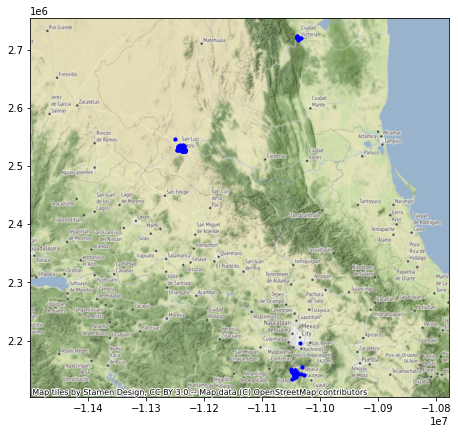

In [17]:
df2 = user_profiles.toPandas()
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude, crs = "EPSG:4326")).to_crs(epsg=3857)
minx2, miny2, maxx2, maxy2 = gdf2.total_bounds


ax2 = gdf2.plot(figsize=(7.5, 7.5), marker='o', color='blue', markersize=10);
ax2.set_xlim(minx2-250000, maxx2+250000)
ax2.set_ylim(miny2-30000, maxy2+30000)
ctx.add_basemap(ax2)

### 1.3 Analisi sui Ristoranti

#### 1.3.1 Metodi di pagamento più diffusi nei ristoranti

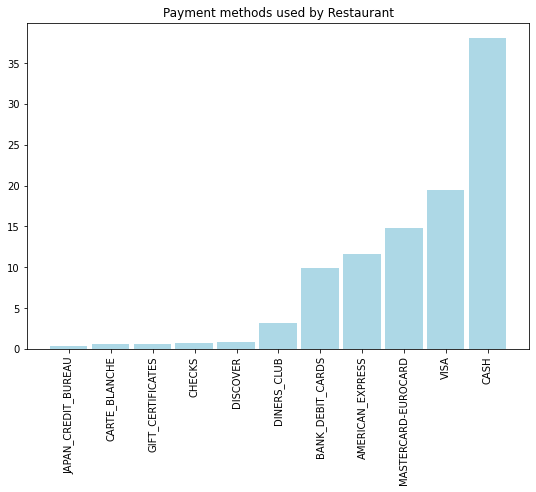

In [18]:
# MapReduce
count_restaurant_payment_methods = payment_method.rdd.map(lambda fields: (fields[1].upper(), 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_restaurant_payment_methods]) #type of payment
y_axis1 = np.array([c[1] for c in count_restaurant_payment_methods]) #count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=90)
plt.title("Payment methods used by Restaurant")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.3.2 Alcolici serviti nei ristoranti

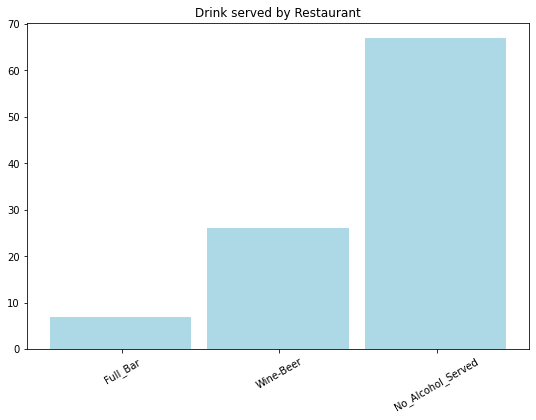

In [19]:
# MapReduce
count_restaurant_drink_type = locations.rdd.map(lambda fields: (fields[11], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_restaurant_drink_type]) #type of drink
y_axis1 = np.array([c[1] for c in count_restaurant_drink_type]) #count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Drink served by Restaurant")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.3.3 Livello dei prezzi dei ristoranti

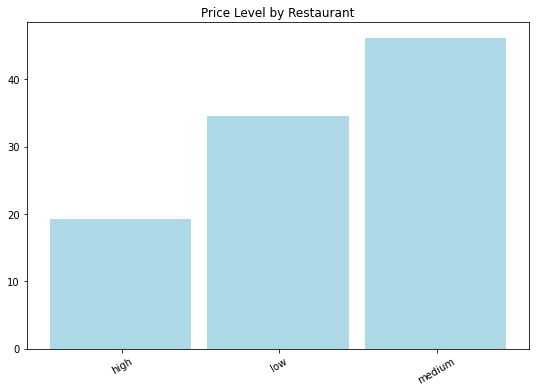

In [20]:
# MapReduce
count_restaurant_price_level = locations.rdd.map(lambda fields: (fields[15], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_restaurant_price_level]) #price level
y_axis1 = np.array([c[1] for c in count_restaurant_price_level]) #count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Price Level by Restaurant")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.3.4 Permesso di fumare nel ristorante

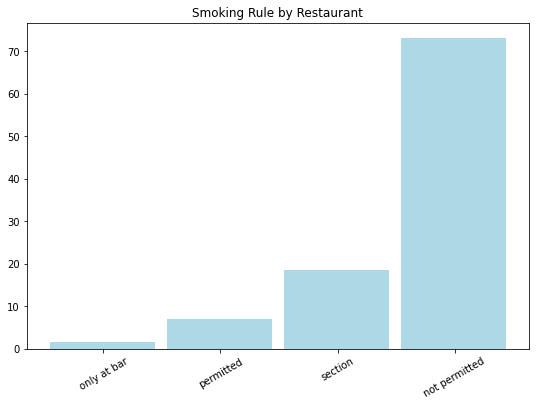

In [21]:
# MapReduce
count_restaurant_smoking_rule = locations.rdd.map(lambda fields: (fields[12], 1)).reduceByKey(lambda x, y: x + y).collect();            count_restaurant_smoking_rule.pop(0); count_restaurant_smoking_rule.pop(3); count_restaurant_smoking_rule.append(('not permitted',95))

x_axis1 = np.array([c[0] for c in count_restaurant_smoking_rule]) #smoke rule
y_axis1 = np.array([c[1] for c in count_restaurant_smoking_rule]) #count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Smoking Rule by Restaurant")
fig = plt.gcf()
fig.set_size_inches(9, 6)

#### 1.3.5 Ristoranti per tipologia di cucina


<AxesSubplot:ylabel='placeID'>

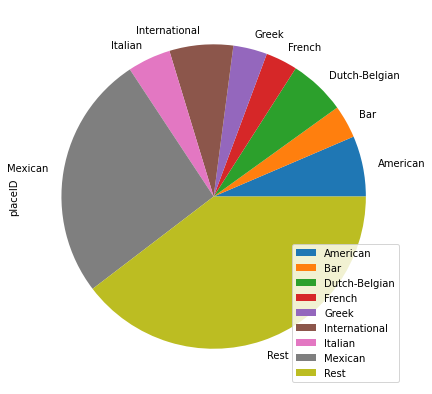

In [22]:
restaurant_cuisine = cuisine.toPandas()
b = restaurant_cuisine.groupby('Rcuisine').agg('count')

# Group minor contributors in "Rest" slice
b.loc['Rest'] = 0
for index, row in b.iterrows():
    if row['placeID'] < 30:
        b.loc['Rest'] = b.loc['Rest'] + row['placeID']
for index, row in b.iterrows():
    if row['placeID'] < 30:
        b.drop(index, inplace=True)

# Pie Plot
b.plot.pie(y="placeID", figsize=(7, 7))

#### 1.3.6 Posizione dei ristoranti presenti nel dataset

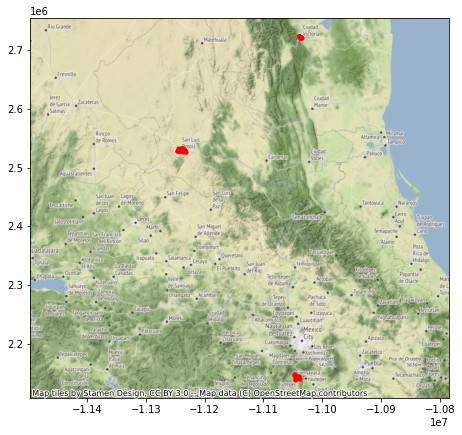

In [23]:
df1 = locations.toPandas()
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitude, df1.latitude, crs = "EPSG:4326")).to_crs(epsg=3857)
minx1, miny1, maxx1, maxy1 = gdf1.total_bounds


ax1 = gdf1.plot(figsize=(7.5, 7.5), marker='o', color='red', markersize=10);
ax1.set_xlim(minx1-250000, maxx1+250000)
ax1.set_ylim(miny1-30000, maxy1+30000)
ctx.add_basemap(ax1)

---

## 2. Ricerca di relazioni fra alcune caratteristiche di un ristorante e la valutazione ricevuta.


### 2.1 Ricerca di una possibile relazione fra ristoranti valutati in maniera eccellente (punteggio 2 in tutte le classi) e tipologia di cucina

<AxesSubplot:xlabel='Rcuisine'>

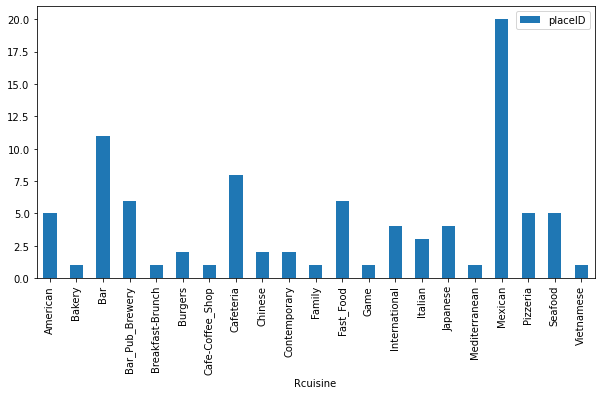

In [24]:
cuisine.createOrReplaceTempView("cuisine")
ratings.createOrReplaceTempView("ratings")

sdf0 = spark.sql("""
    SELECT ratings.placeID, Rcuisine
    FROM ratings 
    LEFT JOIN cuisine ON ratings.placeID=cuisine.placeID 
    WHERE rating=2 AND food_rating=2 AND service_rating=2 AND Rcuisine IS NOT NULL
    ORDER BY ratings.placeID
""")
pdf0 = sdf0.toPandas()

last_place_id = 0
last_cuisine = ""
for index, row in pdf0.iterrows():
    if row["placeID"] == last_place_id and row["Rcuisine"] == last_cuisine:
        pdf0.drop(index, inplace=True)
    else:
        last_place_id = row["placeID"]
        last_cuisine = row["Rcuisine"]

a = pdf0.groupby("Rcuisine").count()
a.plot.bar(figsize=(10, 5))

<AxesSubplot:xlabel='Rcuisine'>

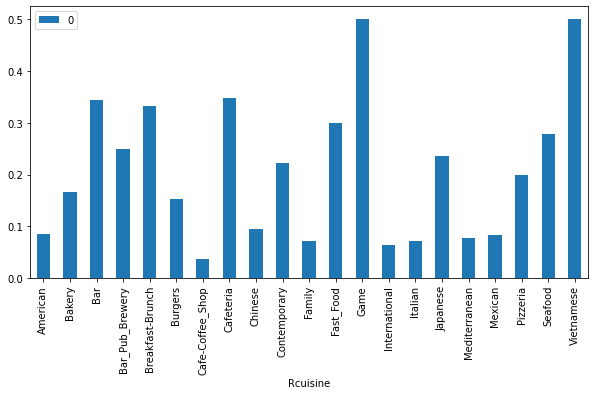

In [25]:
# Normalization on the total number of restaurants for each cuisine

b = restaurant_cuisine.groupby('Rcuisine').agg('count')
merge1 = pd.merge(a, b, on="Rcuisine")

pdf1n = merge1.apply(lambda x: x['placeID_x']/x['placeID_y'], axis=1).to_frame()
pdf1n.plot.bar(figsize=(10, 5))

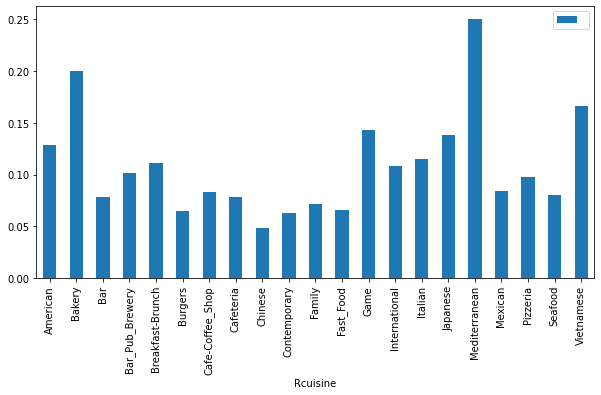

In [26]:
# Normalization on the total number of reviews for each cuisine

sdf2 = spark.sql("""
    SELECT Rcuisine
    FROM ratings 
    LEFT JOIN cuisine ON ratings.placeID=cuisine.placeID 
    WHERE Rcuisine IS NOT NULL
    ORDER BY ratings.placeID
""")
pdf2 = sdf2.toPandas()

c = pdf2.value_counts()
result1 = pd.merge(a, c.rename("reviews_for_cuisine"), on="Rcuisine")

pdf2n = result1.apply(lambda x: x['placeID']/x['reviews_for_cuisine'], axis=1).to_frame()
ax = pdf2n.plot.bar(y=0, figsize=(10, 5))
ax.legend([""]);

### 2.2 Relazione fra presenza di parcheggio e valutazione assegnata al servizio

<AxesSubplot:title={'center':'Parking in restaurants with minimum score'}, ylabel='placeID'>

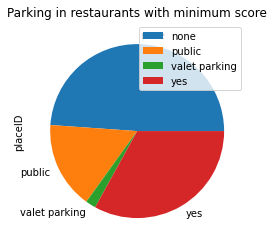

In [27]:
parking.createOrReplaceTempView("parking")

parking_queried_sdf = spark.sql("""
    SELECT ratings.placeID, service_rating, parking_lot
    FROM ratings
    LEFT JOIN parking ON ratings.placeID=parking.placeID
    WHERE service_rating=0
""")

parking_queried_pdf = parking_queried_sdf.toPandas()

lot_type_count = parking_queried_pdf.groupby("parking_lot").count()

lot_type_count.plot.pie(y="placeID", title="Parking in restaurants with minimum score")

<AxesSubplot:title={'center':'Parking in restaurants with maximum score'}, ylabel='placeID'>

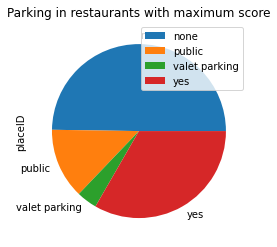

In [28]:
parking.createOrReplaceTempView("parking")

parking_queried_sdf = spark.sql("""
    SELECT ratings.placeID, service_rating, parking_lot
    FROM ratings
    LEFT JOIN parking ON ratings.placeID=parking.placeID
    WHERE service_rating=2
""")

parking_queried_pdf = parking_queried_sdf.toPandas()

lot_type_count = parking_queried_pdf.groupby("parking_lot").count()

lot_type_count.plot.pie(y="placeID", title="Parking in restaurants with maximum score")

## 3. Analisi della domanda e dell'offerta per ogni tipologia di cucina.


Calcolo del rapporto fra numero di clienti che preferiscono una determinata cucina e numero di ristoranti che la offrono.


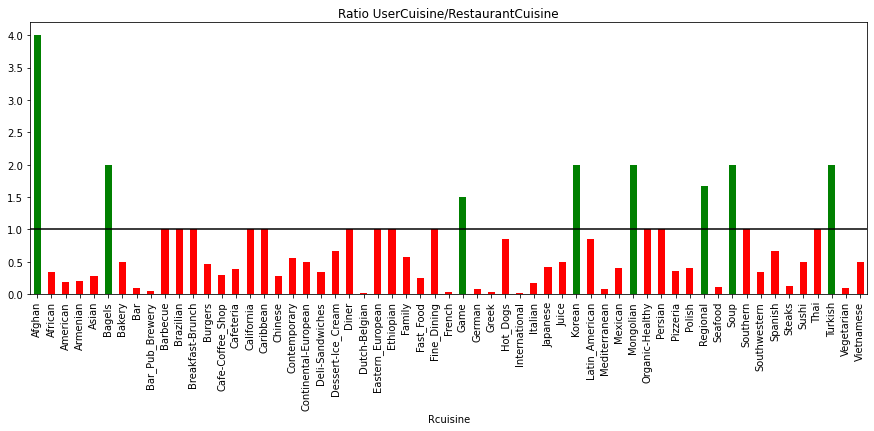

In [29]:
user_cuisine_pdf = user_cuisine.toPandas()
a = user_cuisine_pdf.groupby('Rcuisine').agg('count')
b = restaurant_cuisine.groupby('Rcuisine').agg('count')


count_a = user_cuisine_pdf['userID'].nunique()
count_b = restaurant_cuisine['placeID'].nunique()

a = user_cuisine_pdf.groupby('Rcuisine').agg('count')
b = restaurant_cuisine.groupby('Rcuisine').agg('count')
#a_norm = a.apply(lambda x: x/count_a, axis=0)
#b_norm = b.apply(lambda x: x/count_b, axis=0)
result = pd.merge(a, b, on="Rcuisine")
r1 = result.apply(lambda x: x['userID']/x['placeID'], axis=1).to_frame()

r1['positive'] = r1[0] > 1

ax = r1[0].plot(kind='bar',figsize=(15, 5), title="Ratio UserCuisine/RestaurantCuisine", color=r1.positive.map({True: 'g', False: 'r'}))
ax.axhline(1, color='k', linestyle='-')


## 4. Analisi sul tasso di frequenza dei voti.

### 4.1 Numero di valutazioni e parametri statistici

In [30]:
num_ratings=ratings.count()
num_users = ratings.select("userID").distinct().count()
num_places = ratings.select("placeID").distinct().count()
print("Total Ratings =",num_ratings)
print("Total Users =",num_users)
print("Total Places =",num_places)

# Operations on Ratings
ratings_tot = ratings.rdd.map(lambda fields: int(fields[2]))
max_rating = ratings_tot.reduce(lambda x, y: max(x, y))
min_rating = ratings_tot.reduce(lambda x, y: min(x, y))
mean_rating = ratings_tot.reduce(lambda x, y: x + y) / num_ratings
median_rating = np.median(ratings_tot.collect())
ratings_per_user = num_ratings / num_users
ratings_per_place = num_ratings / num_places
print ("Min rating: %d" % min_rating)
print ("Max rating: %d" % max_rating)
print ("Average rating: %2.2f" % mean_rating)
print ("Median rating: %d" % median_rating)
print ("Average of rating released by user: %2.2f" % ratings_per_user)
print ("Average of ratings receipts per places: %2.2f" % ratings_per_place)


Total Ratings = 1161
Total Users = 138
Total Places = 130
Min rating: 0
Max rating: 2
Average rating: 1.20
Median rating: 1
Average of rating released by user: 8.41
Average of ratings receipts per places: 8.93


### 4.2 Tasso di utilizzo di ogni voto

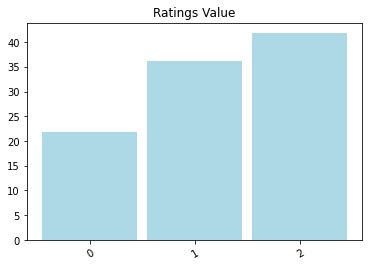

In [31]:
# MapReduce
count_ratings_value = ratings.rdd.map(lambda fields: (fields[2], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_ratings_value]) #ratings
y_axis1 = np.array([c[1] for c in count_ratings_value]) #count

# Order datas
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Normalize datas and convert to percentage
y_axis_normed = y_axis / y_axis.sum() * 100

# Create chart
pos = np.arange(len(x_axis))
width = 0.9
ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
plt.title("Ratings Value")
fig = plt.gcf()

### 4.3 Numero di recensioni scritte per utente

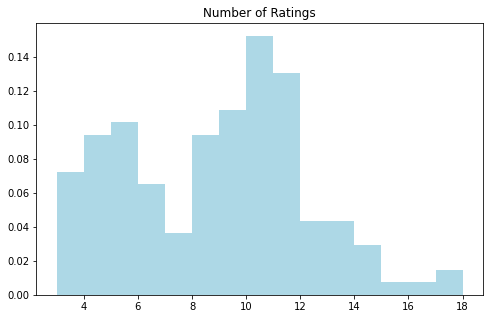

In [32]:
# Group by userID, select the rating and count
user_ratings_grouped_by_user = ratings.rdd.map(lambda fields: (str(fields[0]),int(fields[2]))).groupByKey().map(lambda x : (x[0], len(list(x[1]))))
user_ratings_grouped_by_user.take(5)

user_ratings_byuser_local = user_ratings_grouped_by_user.map(lambda k: k[1]).collect()

plt.hist(user_ratings_byuser_local, bins=15, color='lightblue',density=True)
plt.title("Number of Ratings")
fig = plt.gcf()
fig.set_size_inches(8,5)

### 4.4 Distribuzione della valutazione media del ristorante e del numero di valutazioni

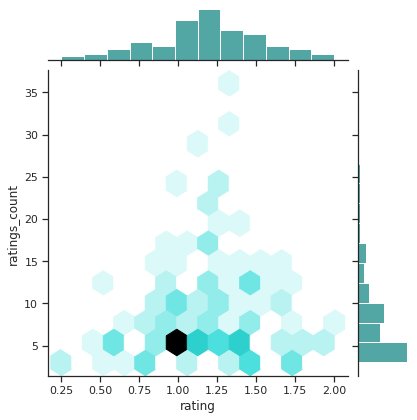

In [33]:
ratings_pdf = ratings.select('userID', 'placeID', 'rating').toPandas()
ratings_pdf['rating'] = ratings_pdf['rating'].astype(int)

ratings_mean_count = pd.DataFrame(ratings_pdf.groupby('placeID')['rating'].mean())
ratings_mean_count['ratings_count'] = pd.DataFrame(ratings_pdf.groupby('placeID')['rating'].count())

sns.set_theme(style="ticks")
g = sns.jointplot(x='rating', y='ratings_count', kind="hex", data=ratings_mean_count, color="#188886")

## 5. Sistema di raccomandazione basato sulla popolarità di un ristorante e sul tipo di cucina più apprezzata.

### 5.1 Determinazione del ristorante più apprezzato

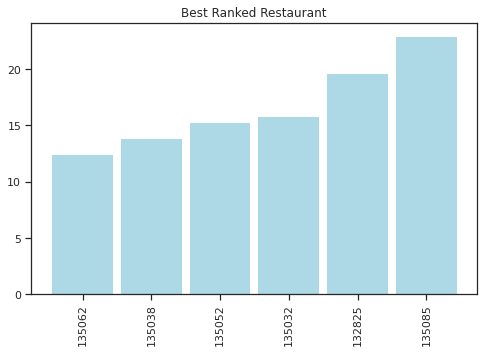

In [34]:
#Raggruppo per Key,[voti], faccio la somma dei voti, e poi ordino la lista per avere le cucine più apprezzate
user_ratings_grouped_by_place = ratings.rdd.map(lambda fields: (int(fields[1]),int(fields[2]))).groupByKey().map(lambda x : (x[0], sum(x[1]))).collect()

ordering_ranking_place = sorted(user_ratings_grouped_by_place,key=lambda l:l[1],reverse=True)[:6]

x_axis1 = np.array([c[0] for c in ordering_ranking_place]) #place ID level
y_axis1 = np.array([c[1] for c in ordering_ranking_place]) #Total of user

#Ordiniamo i nostri dati in modo crescente
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# normalizziamo y-axis in percentuali
y_axis_normed = y_axis / y_axis.sum() * 100

#Figure create
pos = np.arange(len(x_axis))
width = 0.9

#Search the name of the Restaurant
def SearchName(x_axis):
    for k in x_axis:
            str(locations.select("name").filter(locations.placeID == str(k)))

#x_axis = np.array([for k in SearchName(x_axis)])

ax = plt.axes()
ax.set_xticks(pos + (width / 100))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=90)
plt.title("Best Ranked Restaurant")
fig = plt.gcf()
fig.set_size_inches(8,5)


In [35]:
for k in x_axis:
    locations.select("name").filter(locations.placeID == str(k)).show(truncate=False)

+-----------------------------+
|name                         |
+-----------------------------+
|Restaurante El Cielo Potosino|
+-----------------------------+

+---------------------+
|name                 |
+---------------------+
|Restaurant la Chalita|
+---------------------+

+----------------------+
|name                  |
+----------------------+
|La Cantina Restaurante|
+----------------------+

+----------------------------------+
|name                              |
+----------------------------------+
|Cafeteria y Restaurant El Pacifico|
+----------------------------------+

+---------------+
|name           |
+---------------+
|puesto de tacos|
+---------------+

+----------------------+
|name                  |
+----------------------+
|Tortas Locas Hipocampo|
+----------------------+



### 5.2 Ricerca dei ristoranti più apprezzati per tipologia di cucine

In [36]:
locations.createOrReplaceTempView("locations")

sdf = spark.sql("""
    SELECT name, Rcuisine, avg(rating) AS avg_rating
    FROM ratings 
    LEFT JOIN cuisine ON ratings.placeID=cuisine.placeID 
    LEFT JOIN locations ON ratings.placeID=locations.placeID 
    WHERE Rcuisine IS NOT NULL 
    GROUP BY name, Rcuisine
    ORDER BY Rcuisine, avg_rating DESC
""")
pdf = sdf.toPandas()

pdf.drop_duplicates(['Rcuisine'], inplace=True)

display(HTML(tabulate.tabulate(pdf, headers=["Name", "Cuisine", "Rating"], tablefmt='html')))


,Name,Cuisine,Rating
0,tacos los volcanes,American,1.66667
5,little pizza Emilio Portes Gil,Armenian,1.25
6,Chaires,Bakery,1.4
7,Restaurant Bar Hacienda los Martinez,Bar,1.66667
20,emilianos,Bar_Pub_Brewery,2
26,la parroquia,Breakfast-Brunch,1
27,Log Yin,Burgers,1.75
32,Preambulo Wifi Zone Cafe,Cafe-Coffee_Shop,1.58333
33,cafe punta del cielo,Cafeteria,1.83333
42,Restaurant Wu Zhuo Yi,Chinese,1.25


## 6. Sistema di raccomandazione basato su Collaborative Filtering utilizzando MLlib.


### 6.1 Estrazione delle caratteristiche dal dataset e Training del modello

In [45]:
%%time
rating_rdd = ratings.rdd.map(lambda l: (int((l[0])[1:]), int(l[1]), float(l[2])))
rating_rdd.take(5)
(training, test) = rating_rdd.randomSplit([0.8, 0.2])

# Training
rank = 11
num_iterations = 10
model = ALS.train(training, rank, num_iterations)

CPU times: user 21.2 ms, sys: 87 µs, total: 21.3 ms
Wall time: 3.29 s


### 6.2 Top-K

#### Top 10 ristoranti per il cliente 1077

In [38]:
%%time
userID=1077
K=10
TopK_User = model.recommendProducts(userID,K)
display(HTML(tabulate.tabulate(TopK_User, headers=["User", "Restaurant", "Rating"], tablefmt='html')))

User,Restaurant,Rating
1077,135038,1.98831
1077,135085,1.98757
1077,135025,1.93906
1077,132955,1.86829
1077,132754,1.70593
1077,135034,1.6733
1077,135030,1.62661
1077,135041,1.57315
1077,132862,1.56739
1077,134987,1.53578


CPU times: user 5.62 ms, sys: 171 µs, total: 5.79 ms
Wall time: 222 ms


#### Top 10 Customers per il Restaurante El Cielo Potosino

In [39]:
%%time
product=135085
K=10
TopK_User = model.recommendUsers(product,K)
display(HTML(tabulate.tabulate(TopK_User, headers=["User", "Restaurant", "Rating"], tablefmt='html')))

User,Restaurant,Rating
1003,135085,2.40764
1054,135085,2.16034
1056,135085,2.14382
1125,135085,2.11167
1109,135085,2.00987
1036,135085,2.00774
1084,135085,1.99307
1086,135085,1.99252
1090,135085,1.98844
1077,135085,1.98757


CPU times: user 708 µs, sys: 4.16 ms, total: 4.86 ms
Wall time: 114 ms


#### Top 10 Ristoranti suggeriti per ogni utente

In [40]:
model.recommendProductsForUsers(10).take(10)

[(1100,
  (Rating(user=1100, product=134986, rating=2.3261537491600066),
   Rating(user=1100, product=135001, rating=2.0020631560175923),
   Rating(user=1100, product=134996, rating=2.0017105725927364),
   Rating(user=1100, product=135021, rating=1.998495448149157),
   Rating(user=1100, product=134976, rating=1.9966112168307135),
   Rating(user=1100, product=132768, rating=1.9926812601747983),
   Rating(user=1100, product=135000, rating=1.9779590455440803),
   Rating(user=1100, product=132660, rating=1.6998473551160613),
   Rating(user=1100, product=135013, rating=1.5816743899491348),
   Rating(user=1100, product=132608, rating=1.5552637670076097))),
 (1002,
  (Rating(user=1002, product=135034, rating=1.9858049047876967),
   Rating(user=1002, product=132862, rating=1.983534478838359),
   Rating(user=1002, product=135041, rating=1.977923950383182),
   Rating(user=1002, product=132922, rating=1.778982232752449),
   Rating(user=1002, product=135055, rating=1.7707663274746819),
   Rating(u

#### Top 10 Utenti suggeriti per Ristorante

In [41]:
model.recommendUsersForProducts(10).take(10)

[(135108,
  (Rating(user=1055, product=135108, rating=2.21409119168544),
   Rating(user=1021, product=135108, rating=2.134369102850231),
   Rating(user=1126, product=135108, rating=1.985616786161347),
   Rating(user=1111, product=135108, rating=1.9832807017120877),
   Rating(user=1088, product=135108, rating=1.972957212526758),
   Rating(user=1090, product=135108, rating=1.6757192018022409),
   Rating(user=1036, product=135108, rating=1.637837326981222),
   Rating(user=1078, product=135108, rating=1.5913825814693683),
   Rating(user=1137, product=135108, rating=1.5603413567364184),
   Rating(user=1092, product=135108, rating=1.5257612466833408))),
 (132856,
  (Rating(user=1016, product=132856, rating=1.958612106640324),
   Rating(user=1071, product=132856, rating=1.936429298387423),
   Rating(user=1097, product=132856, rating=1.688937448123998),
   Rating(user=1054, product=132856, rating=1.6153333273369093),
   Rating(user=1053, product=132856, rating=1.517831024906926),
   Rating(use

### 6.3 Valutazione delle prestazioni del modello

In [42]:
testdata = test.map(lambda p: (p[0], p[1]))
#Valutazione accuratezza
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = test.map(lambda r: ((int(r[0]), int(r[1])), int(r[2]))).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))
print("Root Mean Squared Error = " + str(math.sqrt(MSE)))

Mean Squared Error = 0.7876526738968739
Root Mean Squared Error = 0.8874979852917266


### 6.4 Valutazione delle prestazioni

#### Iter number

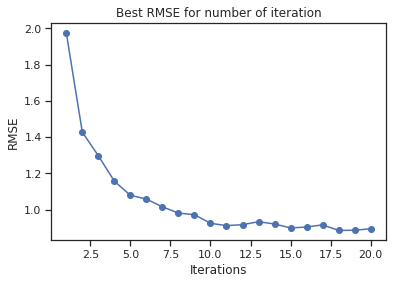

In [43]:
numIter=[1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
RMSE = [1.9763800968925227, 1.427258722435165, 1.2976239193082748, 1.1567760121966948, 1.0789513713815386, 1.0581636223445052, 1.0153131021700221, 0.9806950615468056, 0.9719006866819416, 0.9244689323735364, 0.9114798833746506, 0.9168362430823432, 0.9329233816635875, 0.9205971297989995, 0.8986404851085121, 0.9039275954467955, 0.9157362276052934, 0.8850660687617633, 0.8860140059453971, 0.8943945340441206]
plt.title('Best RMSE for number of iteration')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.plot(numIter,RMSE,'o-')
plt.show()

#### Rank Number

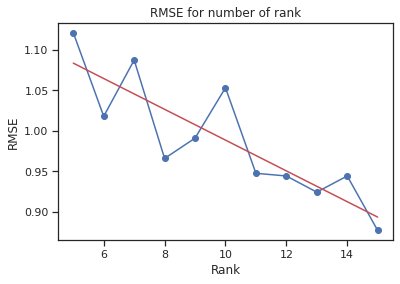

In [44]:
from scipy import stats

numRank=np.array([5,6,7,8,9,10,11,12,13,14,15]) #numIter=10
RMSE=np.array([1.1213525575055718, 1.0179247056068983, 1.0875235518788255, 0.965745237161858, 0.9908779247151901, 1.0532613222086507, 0.9473706205844777, 0.9440520201594996, 0.9240520201594996, 0.9440520201594996, 0.876654208988546])

gradient, intercept, r_value, p_value, std_err = stats.linregress(numRank,RMSE)
mn=np.min(numRank)
mx=np.max(numRank)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(numRank,RMSE,'o-')
plt.plot(x1,y1,'-r')
plt.title('RMSE for number of rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.show()